# Ride Request Predictor
by Florian Titze

github: [n1oftheabove](https://github.com/n1oftheabove)

# Context

This project aimed for building a predictive algorithm that decides whether a driver registered to provide rides for customers of a mobile ride-hailing app and who is requested to take a ride offer, is going to eventually accept that offer or not. Assuming nearby drivers are available, the backend of the app sends a booking requests to a driver, who can accept or declinethe ride. If the driver declines, the app can query one or more extra drivers (under certain conditions), therefore issuing more booking requests for the same ride request.

# Data

This repository contains 3 simpliﬁed log ﬁles representing 24hr worth of various
data:

### **rideRequests.log**

Each line represents a user requesting a ride from a pickup location to an arrival
location.

* `ride_id` : each ride request is assigned a unique identiﬁer
* `created_at` : the epoch when this log entry was appended
* `origin_lat` and `origin_lon` : the pickup location
* `destination_lat` and `destination_lon` : the arrival location

### **bookingRequests.log**

Each line represents an attempt to oﬀer a given ride to a given driver.

* `request_id` : each booking request is assigned a unique identiﬁer
* `logged_at` : the epoch when this log entry was appended
* `ride_id` : each booking request is linked to a user-iniated ride request (see 1.)
* `driver_id` : each booking request is sent to a given driver (see 3.)
* `driver_accepted` : the driver's response (boolean)
* `driver_lat` and `driver_lon` : the location of the driver at the time the booking request was dispatched

### **drivers.log**

Each line represents a driver state change.

* `driver_id` : each driver is assigned a unique identiﬁer
* `logged_at` : the epoch when this log entry was appended
* `new_state` : the driver's state, which can be one of
* `{ connected , disconnected , began_ride , ended_ride }`

# Exercise

Build a model that predicts whether or not a driver will accept a given booking
request.
Use the languages, tools, methods and metrics of your choosing.
Please share your code along with an instructions ﬁle that:
* explains how to run it,
* details your reasoning,
* presents your results/conclusions.

# Necessary libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from functools import reduce

# plotting
import seaborn as sns
import ptitprince as pt

import matplotlib.pyplot as plt

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from imblearn.pipeline import make_pipeline

# helpers
from tqdm.auto import tqdm
from tqdm import tqdm
tqdm.pandas()

# Data Import

In [2]:
br = pd.read_csv("data/bookingRequests.csv")
dr_ = pd.read_csv("data/drivers.csv")
rr = pd.read_csv("data/rideRequests.csv")

In [3]:
dr = dr_.rename(columns={'logged_at':'logged_at_dr'})

In [4]:
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73790 entries, 0 to 73789
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   request_id       73790 non-null  object 
 1   logged_at        73790 non-null  float64
 2   ride_id          73790 non-null  object 
 3   driver_id        73790 non-null  object 
 4   driver_accepted  73790 non-null  bool   
 5   driver_lat       73790 non-null  float64
 6   driver_lon       73790 non-null  float64
dtypes: bool(1), float64(3), object(3)
memory usage: 3.4+ MB


In [5]:
dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51211 entries, 0 to 51210
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   driver_id     51211 non-null  object 
 1   logged_at_dr  51211 non-null  float64
 2   new_state     51211 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [6]:
rr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27635 entries, 0 to 27634
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ride_id          27635 non-null  object 
 1   created_at       27635 non-null  float64
 2   origin_lat       27635 non-null  float64
 3   origin_lon       27635 non-null  float64
 4   destination_lat  27635 non-null  float64
 5   destination_lon  27635 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


In [7]:
br.head()

,request_id,logged_at,ride_id,driver_id,driver_accepted,driver_lat,driver_lon
0,1D6F0B10-46F1-434A-8508-16E26A28DAD6,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,CC5A77A7-6C40-4878-9713-923896116C58,False,48.879980,2.351160
1,7B54D995-FC86-4717-AA40-F273FACA1ACB,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,74254439-F57F-4EDA-969F-081AF8D776A7,False,48.857339,2.293445
2,0F84A2A0-B481-4FDB-B9C2-6E3FB18AA318,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,B7AD21B6-B78B-4405-AFE2-637BEB09D6C4,False,48.856988,2.314611
3,418F37DE-A972-4FB7-8F57-81E60A835F52,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,5411CEF5-C743-4986-9628-FBF8B968B52D,False,48.852935,2.253837
4,10354332-0694-4049-A846-2E9618622F26,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,D422F061-EBC7-4F52-902C-06AA6FAE364C,False,48.846457,2.313746


In [8]:
dr.head()

,driver_id,logged_at_dr,new_state
0,731ED076-A2CF-4BDE-8606-124C609A238D,1.540814e+09,connected
1,B1F4100A-F30A-47DC-B7C8-744B6DFE1506,1.540814e+09,connected
2,3CFCA4F7-7DBF-4E4E-8C65-1FC13096C0F1,1.540814e+09,connected
3,B22A24F8-1B3A-4209-95BD-51C3D2A54E91,1.540814e+09,connected
4,C0762851-2C69-4549-AEC9-61AA14FD85FA,1.540814e+09,connected


In [9]:
rr.head()

,ride_id,created_at,origin_lat,origin_lon,destination_lat,destination_lon
0,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,1.540815e+09,48.867949,2.257649,48.900046,2.292644
1,CBFD3E3A-FECF-43AB-B789-DE74F8ED8B7A,1.540815e+09,48.868174,2.324368,48.847489,2.295885
2,4A1CEC00-8F8D-4678-85EE-D51F39D48709,1.540815e+09,48.890231,2.311160,48.873491,2.299524
3,1247CAAC-990F-46D0-B75A-249E499B9C6B,1.540815e+09,48.850381,2.353253,48.890080,2.325938
4,1B3EFF91-9873-438E-87EB-04BEAE6C7376,1.540815e+09,48.830886,2.417611,48.845113,2.268306


# Build the ML ready data

In order to enrich the booking requests issued to every driver with the ride requests data, we need a left join of the attempted offers `bookingRequests` to the `rideRequests` table

In [8]:
df_rides = pd.merge(
    br,
    rr,
    how="left",
    on='ride_id',
)

Check for null values

In [9]:
df_rides.isna().sum()

request_id         0
logged_at          0
ride_id            0
driver_id          0
driver_accepted    0
driver_lat         0
driver_lon         0
created_at         0
origin_lat         0
origin_lon         0
destination_lat    0
destination_lon    0
dtype: int64

Make this a function for pipelining later:

In [10]:
def load_original_data():
    br = pd.read_csv("data/bookingRequests.csv")
    rr = pd.read_csv("data/rideRequests.csv")    
    
    return pd.merge(
        br,
        rr,
        how="left",
        on='ride_id',
    )

# EDA
## Exploring the data

In [13]:
df_rides.head()

,request_id,logged_at,ride_id,driver_id,driver_accepted,driver_lat,driver_lon,created_at,origin_lat,origin_lon,destination_lat,destination_lon
0,1D6F0B10-46F1-434A-8508-16E26A28DAD6,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,CC5A77A7-6C40-4878-9713-923896116C58,False,48.879980,2.351160,1.540815e+09,48.867949,2.257649,48.900046,2.292644
1,7B54D995-FC86-4717-AA40-F273FACA1ACB,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,74254439-F57F-4EDA-969F-081AF8D776A7,False,48.857339,2.293445,1.540815e+09,48.867949,2.257649,48.900046,2.292644
2,0F84A2A0-B481-4FDB-B9C2-6E3FB18AA318,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,B7AD21B6-B78B-4405-AFE2-637BEB09D6C4,False,48.856988,2.314611,1.540815e+09,48.867949,2.257649,48.900046,2.292644
3,418F37DE-A972-4FB7-8F57-81E60A835F52,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,5411CEF5-C743-4986-9628-FBF8B968B52D,False,48.852935,2.253837,1.540815e+09,48.867949,2.257649,48.900046,2.292644
4,10354332-0694-4049-A846-2E9618622F26,1.540815e+09,B00F0085-6EB7-4AC0-A1A8-3AD37F872D06,D422F061-EBC7-4F52-902C-06AA6FAE364C,False,48.846457,2.313746,1.540815e+09,48.867949,2.257649,48.900046,2.292644


## Over which time do the data span?

In [15]:
# booking request
logged_at_dt = pd.to_datetime(df_rides.logged_at, unit='s')

# ride request
created_at_dt = pd.to_datetime(df_rides.created_at, unit='s')

# driver state change
logged_at_dr = pd.to_datetime(dr.logged_at_dr, unit='s')

pd.DataFrame({'Min time': [min(logged_at_dt),
                           min(created_at_dt),
                           min(logged_at_dr)],
              'Max time': [max(logged_at_dt),
                           max(created_at_dt),
                           max(logged_at_dr)]},
             index = ['timespan logged at',
                      'timespan created at',
                      'timespan driver state change log']
            )

,Min time,Max time
timespan logged at,2018-10-29 12:04:50.650768640,2018-10-30 11:53:58.996917504
timespan created at,2018-10-29 12:04:49.561193728,2018-10-30 11:53:58.996917504
timespan driver state change log,2018-10-29 12:00:01.116698112,2018-10-30 11:54:29.890972416


All data almost perfectly cover that 24 hour window on 2018-10-29 / 2018-10-30

## Rough statistical overview of numerical columns

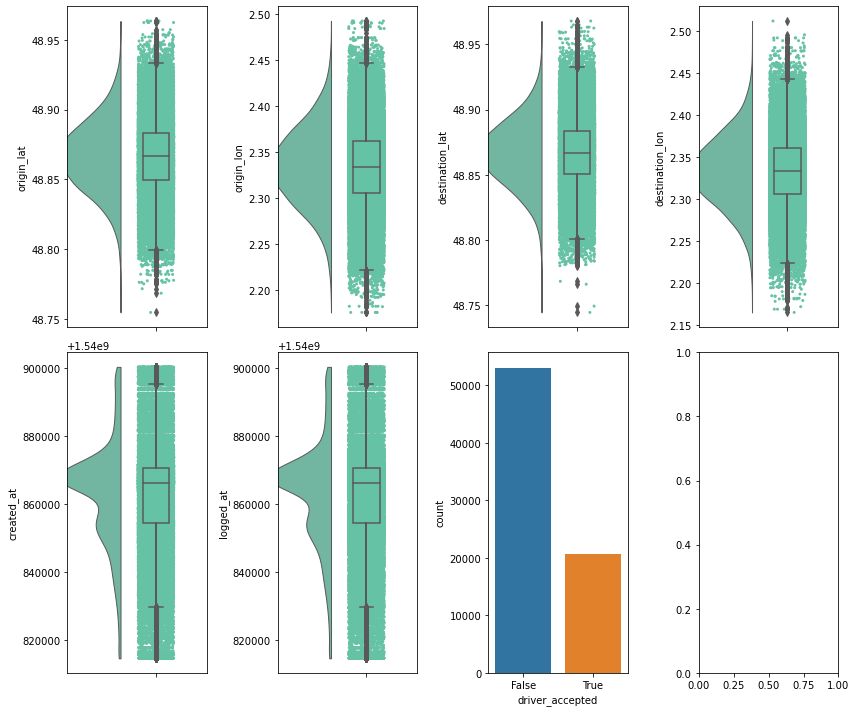

In [15]:
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(12,10))
pt.RainCloud(data=df_rides, y='origin_lat', ax = ax[0,0])
pt.RainCloud(data=df_rides, y='origin_lon', ax = ax[0,1])
pt.RainCloud(data=df_rides, y='destination_lat', ax = ax[0,2])
pt.RainCloud(data=df_rides, y='destination_lon', ax = ax[0,3])
pt.RainCloud(data=df_rides, y='created_at', ax = ax[1,0])
pt.RainCloud(data=df_rides, y='logged_at', ax = ax[1,1])
sns.countplot(data=df_rides, x='driver_accepted', ax=ax[1,2])
plt.tight_layout()

# Observations after EDA and data preparation

* No null values,
* timespans of all 3 tables almost perfectly overlap,
* column names already properly formatted,
* **target variable** is **fairly imbalanced**. Sampling techniques necessary in order to avoid bias.
* geocordinates look almost perfectly normal distributed. Presumably artificially created. If both destination and origin geocoordinates are normally distributed, so will be the distance (which will be another feature)

# Create first baseline model

In [17]:
df1 = df_rides.drop(['request_id', 'ride_id', 'driver_id'], axis=1)

In [18]:
df1.head()

,logged_at,driver_accepted,driver_lat,driver_lon,created_at,origin_lat,origin_lon,destination_lat,destination_lon
0,1.540815e+09,False,48.879980,2.351160,1.540815e+09,48.867949,2.257649,48.900046,2.292644
1,1.540815e+09,False,48.857339,2.293445,1.540815e+09,48.867949,2.257649,48.900046,2.292644
2,1.540815e+09,False,48.856988,2.314611,1.540815e+09,48.867949,2.257649,48.900046,2.292644
3,1.540815e+09,False,48.852935,2.253837,1.540815e+09,48.867949,2.257649,48.900046,2.292644
4,1.540815e+09,False,48.846457,2.313746,1.540815e+09,48.867949,2.257649,48.900046,2.292644


Let's make this a function for pipelining later

In [19]:
def drop_id_columns(df):
    return df.drop(['request_id', 'ride_id', 'driver_id'], axis=1)

In [20]:
X = df1.drop(['driver_accepted'], axis=1)
y = df1.driver_accepted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

The accuracy of the model on test set is: 0.72 
[[10572     0]
 [ 4186     0]]


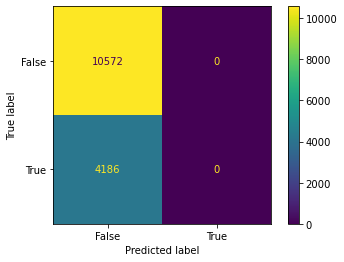

In [21]:
def fit_and_evaluate_cls(X_train, X_test, y_train, y_test):

    cls = LogisticRegression(random_state=0,

                            ).fit(X_train, y_train)

    predictions = cls.predict(X_test)

    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    plot_confusion_matrix(cls, X_test, y_test)
    plt.show()
    
fit_and_evaluate_cls(X_train, X_test, y_train, y_test)

No prediction quality with regards to `driver_accepted = True` which was expected due to data imbalance

### Applying sampling (SMOTE) on the training data

In [22]:
smote = SMOTE()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)


X_sm, y_sm = smote.fit_resample(X_train_sc, y_train)
y_sm.value_counts()

False    42535
True     42535
Name: driver_accepted, dtype: int64

The accuracy of the model on test set is: 0.72 
[[10572     0]
 [ 4186     0]]


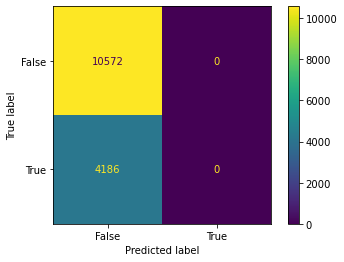

In [23]:
fit_and_evaluate_cls(X_sm, X_test, y_sm, y_test)

# Feature Engineering

### 1. Distances

Intuitive thought:
Three distances could influence a drivers decision to accept:

* his/her distance to the customer - will be called `driver_origin_distance`
* customer's distance to the target - will be called `origin_destination_distance`
* drivers distance to the target - will be called `driver_destination_distance`

I will calculate all of them as three new features

In [24]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # earth radius
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

def calc_dist(row, from_lat, from_lon, to_lat, to_lon):
    return haversine_distance(row[from_lat], row[from_lon], row[to_lat], row[to_lon])

def add_distances(df):
    """
    adds three columns of distances in km to the original dataframe and returns that dataframe 
    """
    
    
    df['driver_origin_distance'] = df.apply(lambda row: calc_dist(row,
                                                                  "driver_lat",
                                                                  "driver_lon",
                                                                  "origin_lat",
                                                                  "origin_lon"
                                                                 ),
                                            axis=1
                                           )
    df['origin_destination_distance'] = df.apply(lambda row: calc_dist(row,
                                                                  "origin_lat",
                                                                  "origin_lon",
                                                                  "destination_lat",
                                                                  "destination_lon"
                                                                 ),
                                            axis=1
                                           )
    df['driver_destination_distance'] = df.apply(lambda row: calc_dist(row,
                                                                  "driver_lat",
                                                                  "driver_lon",
                                                                  "destination_lat",
                                                                  "destination_lon"
                                                                 ),
                                            axis=1
                                           )
    return df


###  2. distance of ride request from the city center (not yet implemented)

Since we saw that all geo coordinates are almost perfectly normally distributed, we assume that the mean of it corresponds to the city center. In a case of a city which shows a high degree of point symmetry like Paris, where it can be assumed that most rides are requested in the city center, one also could choose this as a reference point for this feature.
A more sophisticated approach would probably be to cluster the multitude of geocoordinates of all ride requests of the past with an unsupervised algorithm e.g. K-Means, build not only one but multiple cluster centers (which would correspond roughly to more "vivid" areas) and then calculate for every ride request the distance between the rider and the driver. The idea being that the closer a rider requests a ride to one of the vivid areas, the earlier the driver hopes to finish the ride also within that area and pick up the next rider in quicker succession

###  3. time difference between `created_at` and `logged_at`

A driver's decision might be influenced by the time that has passed between

In [25]:
def add_timediff(df):
    """
    adds time difference between created and logged 
    """
    
    
    df['created_logged_time_diff'] = df.apply(lambda row: row.logged_at - row.created_at, 
                                              axis=1
                                             )

    return df

### ~~4. state of the driver when booking request is made~~ (omitted, since request are only made to connected and non-in-a-ride-drivers)

I want to create a new feature telling us in which state a specific driver was in when a booking request was made, which could be a could predictor for driver_accepted. For that I make use of the `drivers.log` data. These data only contain information about the driver's state when it changed and when that changed was logged. Therefore the "previous" state and its timestamp of every log must be found.

In [26]:
dr.head()

,driver_id,logged_at_dr,new_state
0,731ED076-A2CF-4BDE-8606-124C609A238D,1.540814e+09,connected
1,B1F4100A-F30A-47DC-B7C8-744B6DFE1506,1.540814e+09,connected
2,3CFCA4F7-7DBF-4E4E-8C65-1FC13096C0F1,1.540814e+09,connected
3,B22A24F8-1B3A-4209-95BD-51C3D2A54E91,1.540814e+09,connected
4,C0762851-2C69-4549-AEC9-61AA14FD85FA,1.540814e+09,connected


#### ~~4.1 Enriching `drivers.log` dataframe `dr` with previous states and timestamps~~

In [27]:
# generate a new column 'old_state'
# inefficient lookup, needs to be improved
# when handling larger data

prev_states = []
prev_logged_at = []
for i, row in tqdm(dr.iterrows()):
    df_temp = dr[dr.driver_id == row.driver_id]
    prev = df_temp.iloc[df_temp.index.get_loc(i) - 1]
    if prev.logged_at_dr > row.logged_at_dr:
        prev_states.append(np.NaN)
        prev_logged_at.append(np.NaN)
    else:
        prev_states.append(prev.new_state)
        prev_logged_at.append(prev.logged_at_dr)

51211it [02:10, 393.32it/s]


In [28]:
dr['previous_state'] = prev_states
dr['prev_logged_at_dr'] = prev_logged_at

In [29]:
dr.head()

,driver_id,logged_at_dr,new_state,previous_state,prev_logged_at_dr
0,731ED076-A2CF-4BDE-8606-124C609A238D,1.540814e+09,connected,NaN,NaN
1,B1F4100A-F30A-47DC-B7C8-744B6DFE1506,1.540814e+09,connected,NaN,NaN
2,3CFCA4F7-7DBF-4E4E-8C65-1FC13096C0F1,1.540814e+09,connected,NaN,NaN
3,B22A24F8-1B3A-4209-95BD-51C3D2A54E91,1.540814e+09,connected,NaN,NaN
4,C0762851-2C69-4549-AEC9-61AA14FD85FA,1.540814e+09,connected,NaN,NaN


#### 3.2. Feature engineering: `was_in_ride`, `was_connected` (redundant feature)

In [30]:
def create_was_in_ride(row):
    if row.new_state == "ended_ride":
        return True
    elif row.new_state != row.new_state:
        return np.NaN
    else:
        return False

def create_was_connected(row):
    if row.new_state in ('disconnected', 'ended_ride', 'began_ride'):
        return True
    elif row.new_state != row.new_state:
        return np.NaN
    else:
        return False

dr['was_in_ride'] = dr.apply(lambda row: create_was_in_ride(row), axis=1)
dr['was_connected'] = dr.apply(lambda row: create_was_connected(row), axis=1)

In [31]:
def get_status_from_id_and_time(row, dr, status='was_in_ride'):
    """
    Scans through the merged booking request + ride requests dataframe rowwise.
    For every driver_id and logged_at timestamp value, it looks up the dataframe dr derived from the drivers.log
    table and finds the current state in which the driver was in the moment the request to the driver was
    made.
    
    status: {"new_state", "previous_state", "was_in_ride", "was_connected"}
    
    """
    
    driver_id = row.driver_id
    logged_at = row.logged_at
    
    # building a temporary df for the specific driver_id
    temp_df = dr[dr.driver_id == driver_id]
    
    # need to look up the temp_df for two cases:
    # case1: time of riderequest falls between two log events
    # case2: time of riderequest before first logged event (no data before)
    result_row = temp_df[((temp_df.prev_logged_at_dr < logged_at) \
                          & (temp_df.logged_at_dr > logged_at)) \
                         | ((temp_df.prev_logged_at_dr!=temp_df.prev_logged_at_dr) \
                            & (temp_df.logged_at_dr > logged_at))
                        ]
    # return value of "search result"
    if len(result_row) == 1:
        return result_row[status].item()
    # but return NaN when search result empty
    else:
        return np.NaN

In [32]:
# df_rides_new = (df_rides
#                 .apply(lambda row: get_status_from_id_and_time(row,
#                                                                status="was_in_ride"),
#                        axis=1)
#                )

In [33]:
# df_rides_new.value_counts()

I conclude that booking requests are only sent out to drivers who are free. A feature `was_in_ride` doesn't therefore make sense.

#### 3.3. Feature engineering: Number of rides at the time of booking request since connected

In [34]:
# let's take the original unaltered `drivers.log`
dr_.head()

,driver_id,logged_at,new_state
0,731ED076-A2CF-4BDE-8606-124C609A238D,1.540814e+09,connected
1,B1F4100A-F30A-47DC-B7C8-744B6DFE1506,1.540814e+09,connected
2,3CFCA4F7-7DBF-4E4E-8C65-1FC13096C0F1,1.540814e+09,connected
3,B22A24F8-1B3A-4209-95BD-51C3D2A54E91,1.540814e+09,connected
4,C0762851-2C69-4549-AEC9-61AA14FD85FA,1.540814e+09,connected


In the `drivers.log` table I try to get an overview of how many rides each driver accumulated. For that I first build a function that generates a column of `True` when the `new_state` is `"end_ride"` - which corresponds to one finished ride.

In [35]:
dr_["is_ended_ride"] = dr_.new_state.apply(lambda x: x=='ended_ride')

In [36]:
dr_.head()

,driver_id,logged_at,new_state,is_ended_ride
0,731ED076-A2CF-4BDE-8606-124C609A238D,1.540814e+09,connected,False
1,B1F4100A-F30A-47DC-B7C8-744B6DFE1506,1.540814e+09,connected,False
2,3CFCA4F7-7DBF-4E4E-8C65-1FC13096C0F1,1.540814e+09,connected,False
3,B22A24F8-1B3A-4209-95BD-51C3D2A54E91,1.540814e+09,connected,False
4,C0762851-2C69-4549-AEC9-61AA14FD85FA,1.540814e+09,connected,False


Number of requested (and also completed rides) of that rider during the time:

In [37]:
def get_no_of_past_rides_from_id_and_time(row, dr_):
    """
    Scans through the merged booking request + ride requests dataframe rowwise.
    For every driver_id and logged_at timestamp value, it looks up the dataframe dr derived from the drivers.log
    table and determines how many rides have been completed up to that time. Then returns that number.
    
    """
    
    driver_id = row.driver_id
    logged_at = row.logged_at
    
    # building a temporary df for the specific driver_id
    temp_df = dr_[(dr_.driver_id == driver_id)]
    
    # case: driver only connected and disconnected -> no rides
    if len(temp_df) == 2:
        return 0
    
    temp_df = temp_df[temp_df.new_state=="began_ride"]
    
    # add "rides done" column to temp_df
    temp_df['rides_done'] = range(len(temp_df))
    for i in range(len(temp_df)):
        if i==0 and logged_at < temp_df.iloc[i]['logged_at']:
            #print("if")
            return temp_df.iloc[i]['rides_done']
        elif logged_at > temp_df.iloc[i-1]['logged_at'] and logged_at < temp_df.iloc[i]['logged_at']:
            #print("elif")
            return temp_df.iloc[i]['rides_done']
        else:
            #print("else")
            return temp_df.iloc[-1]['rides_done']

Put this into a function for pipelining

In [38]:
def add_no_of_past_rides(df):
    print(df.columns)
    df['no_of_accumulated_rides']=(df.apply(lambda row: get_no_of_past_rides_from_id_and_time(row, dr), axis=1))
    return df

## Pipelined preprocessing and ML

In [42]:
over_sample = SMOTE(random_state=0)
under_sample = RandomUnderSampler(sampling_strategy=0.5)
cls = LogisticRegression(random_state=0,
                         solver='lbfgs',
                         multi_class='ovr')
scaler = StandardScaler()

dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

In [ ]:
# build features & labels with predefined preprocessing /engineering functions
df=(load_original_data()
    .pipe(add_distances)
    .pipe(add_timediff)
    .pipe(add_no_of_past_rides)
    .pipe(drop_id_columns)
   )

Save to pickle

In [ ]:
pd.to_pickle(df, "data/df_full_features.pkl")

#### Random Forest

Performing a fit & evaluation using a GridSearch for the number of trees

In [43]:
df = pd.read_pickle("data/df_full_features.pkl")

X = df.drop(['driver_accepted'], axis=1)
y = df.driver_accepted

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

pipe = make_pipeline(scaler, over_sample, rfc)
param_grid = {
    'randomforestclassifier__n_estimators': [100, 110, 120, 130, 140, 150, 160, 170],
    'randomforestclassifier__warm_start': [True]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, verbose=4)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameter (CV score=0.844):
{'randomforestclassifier__n_estimators': 120, 'randomforestclassifier__warm_start': True}


In [44]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.85      0.89     10543
        True       0.69      0.83      0.75      4215

    accuracy                           0.84     14758
   macro avg       0.81      0.84      0.82     14758
weighted avg       0.86      0.84      0.85     14758



In [45]:
# get predicted probabilities
target_proba = search.predict_proba(X_test)[:,1]

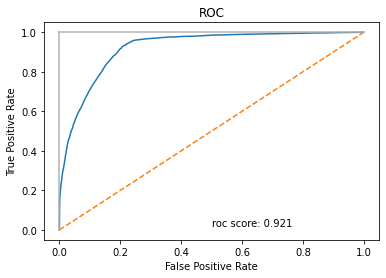

In [46]:
# create true (sensitivity) and false positive rates
fpr, tpr, threshold = roc_curve(y_test, target_proba)
roc_score = round(roc_auc_score(y_test, target_proba),3)

plt.title("ROC")
plt.plot(fpr, tpr)
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c=".7"), plt.plot([1,1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.annotate(f"roc score: {roc_score}", (0.5, 0.02) )
plt.show()

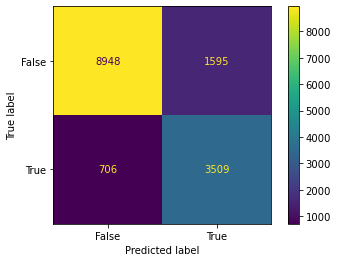

In [47]:
plot_confusion_matrix(search, X_test, y_test);

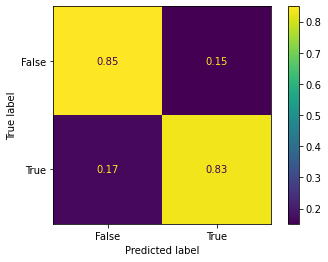

In [48]:
plot_confusion_matrix(search, X_test, y_test, normalize='true');

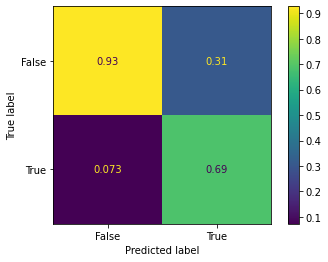

In [49]:
plot_confusion_matrix(search, X_test, y_test, normalize='pred')

In [50]:
y_test.value_counts()

False    10543
True      4215
Name: driver_accepted, dtype: int64

#### Feature importance

In [51]:
feat_i = search.best_estimator_._final_estimator.feature_importances_
feat_i_df = (pd.DataFrame({c:v for c, v in zip(X_train.columns,
                                              feat_i)},
                         index=['feature_importance'])

             .T
             .reset_index()
             .rename({'index':'feature'})
             .sort_values(by='feature_importance', ascending=False)
            )


In [52]:
feat_i_df

,index,feature_importance
8,driver_origin_distance,0.200994
0,logged_at,0.191898
3,created_at,0.189316
12,no_of_accumulated_rides,0.088503
9,origin_destination_distance,0.066530
10,driver_destination_distance,0.050260
2,driver_lon,0.035077
1,driver_lat,0.034835
4,origin_lat,0.033269
5,origin_lon,0.033038


[CV 5/10] END randomforestclassifier__n_estimators=100, randomforestclassifier__warm_start=True;, score=0.840 total time=  41.9s
[CV 5/10] END randomforestclassifier__n_estimators=110, randomforestclassifier__warm_start=True;, score=0.841 total time=  48.1s
[CV 1/10] END randomforestclassifier__n_estimators=130, randomforestclassifier__warm_start=True;, score=0.843 total time=  52.7s
[CV 4/10] END randomforestclassifier__n_estimators=140, randomforestclassifier__warm_start=True;, score=0.848 total time=  54.1s
[CV 6/10] END randomforestclassifier__n_estimators=150, randomforestclassifier__warm_start=True;, score=0.846 total time= 1.0min
[CV 8/10] END randomforestclassifier__n_estimators=160, randomforestclassifier__warm_start=True;, score=0.838 total time= 1.1min
[CV 3/10] END randomforestclassifier__n_estimators=100, randomforestclassifier__warm_start=True;, score=0.841 total time=  43.0s
[CV 10/10] END randomforestclassifier__n_estimators=110, randomforestclassifier__warm_start=True;

[CV 1/10] END randomforestclassifier__n_estimators=100, randomforestclassifier__warm_start=True;, score=0.839 total time=  42.1s
[CV 8/10] END randomforestclassifier__n_estimators=110, randomforestclassifier__warm_start=True;, score=0.837 total time=  47.9s
[CV 10/10] END randomforestclassifier__n_estimators=120, randomforestclassifier__warm_start=True;, score=0.840 total time=  49.3s
[CV 2/10] END randomforestclassifier__n_estimators=140, randomforestclassifier__warm_start=True;, score=0.851 total time=  55.1s
[CV 4/10] END randomforestclassifier__n_estimators=150, randomforestclassifier__warm_start=True;, score=0.846 total time=  59.4s
[CV 6/10] END randomforestclassifier__n_estimators=160, randomforestclassifier__warm_start=True;, score=0.849 total time= 1.1min
[CV 8/10] END randomforestclassifier__n_estimators=170, randomforestclassifier__warm_start=True;, score=0.837 total time=  53.5s
[CV 1/10] END randomforestclassifier__n_estimators=110, randomforestclassifier__warm_start=True;

In [62]:
# pickle the model
pd.to_pickle(search.best_estimator_._final_estimator, "models/rfc_120trees.pkl")

# pickle whole search
pd.to_pickle(search, "models/rfc_120trees_search.pkl")

# Data visualisations

Inspecting the `drivers.log`. How are the first log entries of every driver distributed over the day?

<AxesSubplot:>

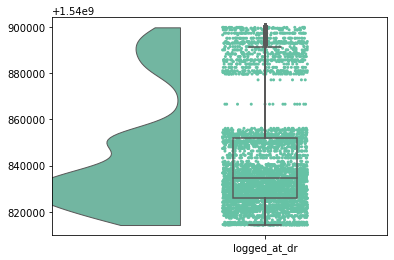

In [63]:
pt.RainCloud(data=dr.groupby('driver_id').agg({'logged_at_dr':'min'}).reset_index())

Number of logs per individual driver

<AxesSubplot:>

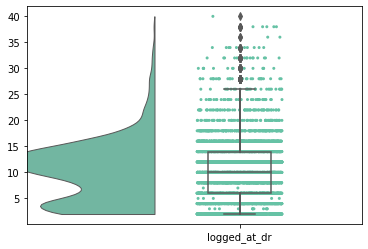

In [64]:
pt.RainCloud(data=dr.groupby('driver_id').agg({'logged_at_dr':'count'}).reset_index())

Plots of the features with respect to the target variable (e.g. hued with seaborn) can give initial impressions regarding their predictive power, for example when there's an overweight of one class of the target variable towards one direction of the numeric feature.

Plotting every ride request hued by `driver_accepted` with the number of accumulated rides for that specific driver up to this point **vs.** the distance of the rider to his/her destination. This is to highlight the importance 

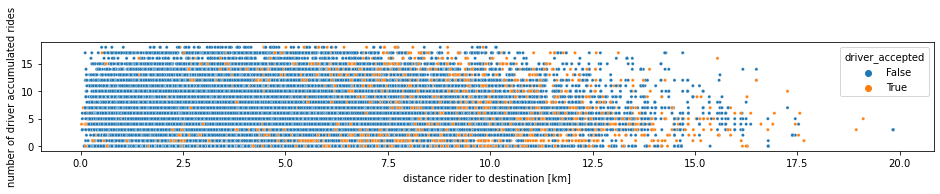

In [65]:
fig, ax = plt.subplots(figsize=(16,2))
sns.scatterplot(data=df,
                x='origin_destination_distance',
                y='no_of_accumulated_rides',
                hue='driver_accepted',
               s=10,
               ax=ax);
plt.xlabel('distance rider to destination [km]');
plt.ylabel('number of driver accumulated rides');

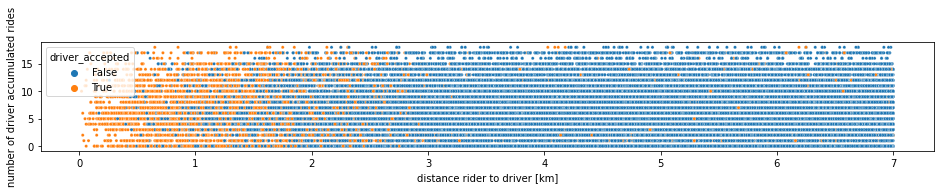

In [66]:
fig, ax = plt.subplots(figsize=(16,2))
sns.scatterplot(data=df,
                x='driver_origin_distance',
                y='no_of_accumulated_rides',
                hue='driver_accepted',
               s=10,
               ax=ax);
plt.xlabel('distance rider to driver [km]');
plt.ylabel('number of driver accumulated rides');

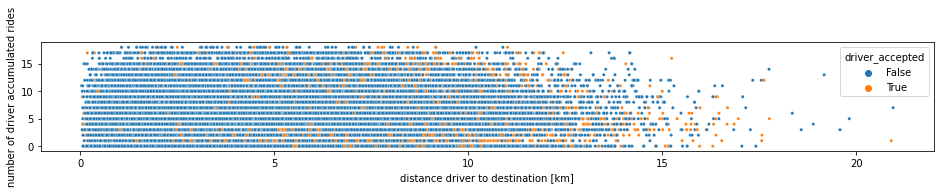

In [67]:
fig, ax = plt.subplots(figsize=(16,2))
sns.scatterplot(data=df,
                x='driver_destination_distance',
                y='no_of_accumulated_rides',
                hue='driver_accepted',
               s=10,
               ax=ax);
plt.xlabel('distance driver to destination [km]');
plt.ylabel('number of driver accumulated rides');

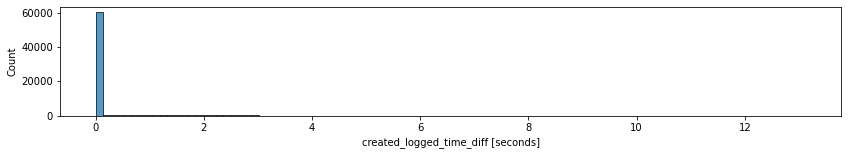

In [68]:
fig, ax = plt.subplots(figsize=(14,2))
sns.histplot(df.created_logged_time_diff, bins=100,)
plt.xlabel('created_logged_time_diff [seconds]');

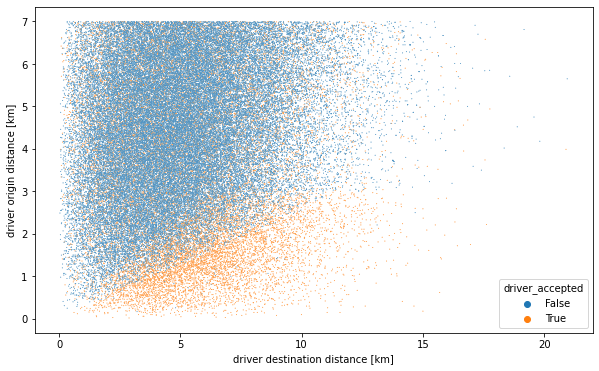

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df,
                x='driver_destination_distance',
                y='driver_origin_distance',
                hue='driver_accepted',
               s=1,
               ax=ax);
plt.xlabel('driver destination distance [km]');
plt.ylabel('driver origin distance [km]');

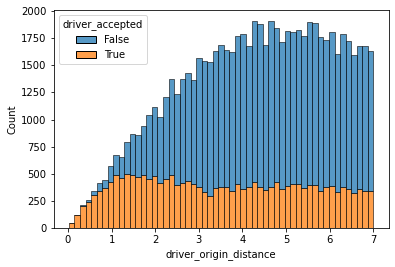

In [70]:
sns.histplot(data=df, x="driver_origin_distance", hue="driver_accepted", multiple="stack");

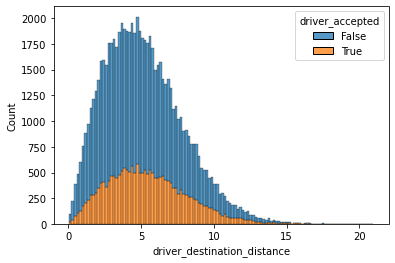

In [71]:
sns.histplot(data=df, x="driver_destination_distance", hue="driver_accepted", multiple="stack");

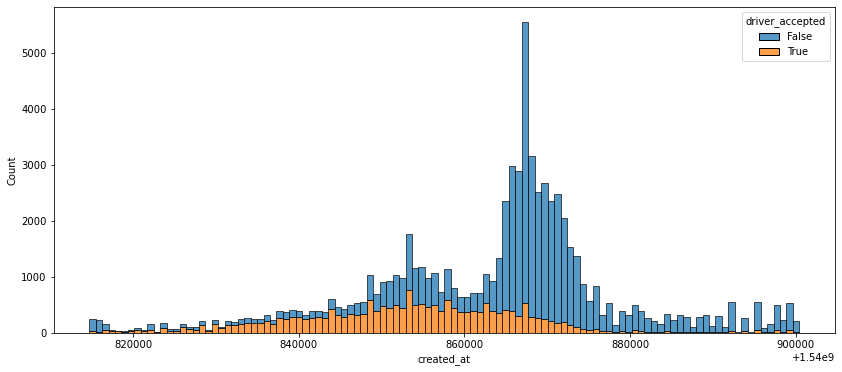

In [72]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=df, x="created_at", hue="driver_accepted", multiple="stack");

<AxesSubplot:xlabel='logged_at', ylabel='Count'>

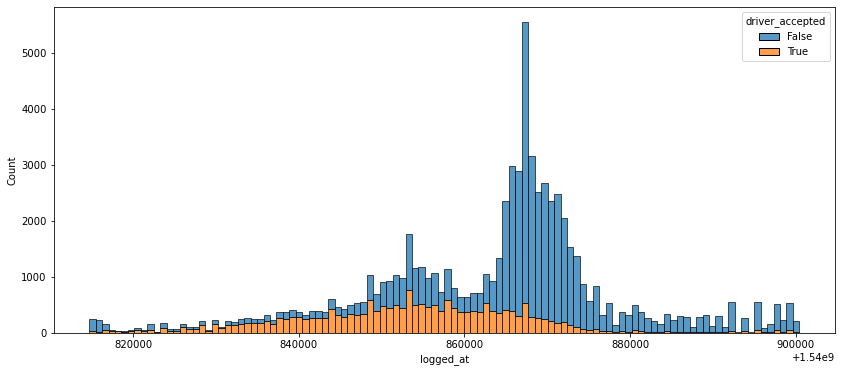

In [73]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=df, x="logged_at", hue="driver_accepted", multiple="stack")

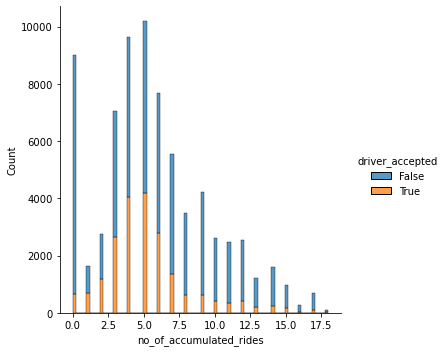

In [74]:
#fig, ax = plt.subplots(figsize=(14,6))
sns.displot(data=df, x="no_of_accumulated_rides", hue="driver_accepted", multiple="stack")

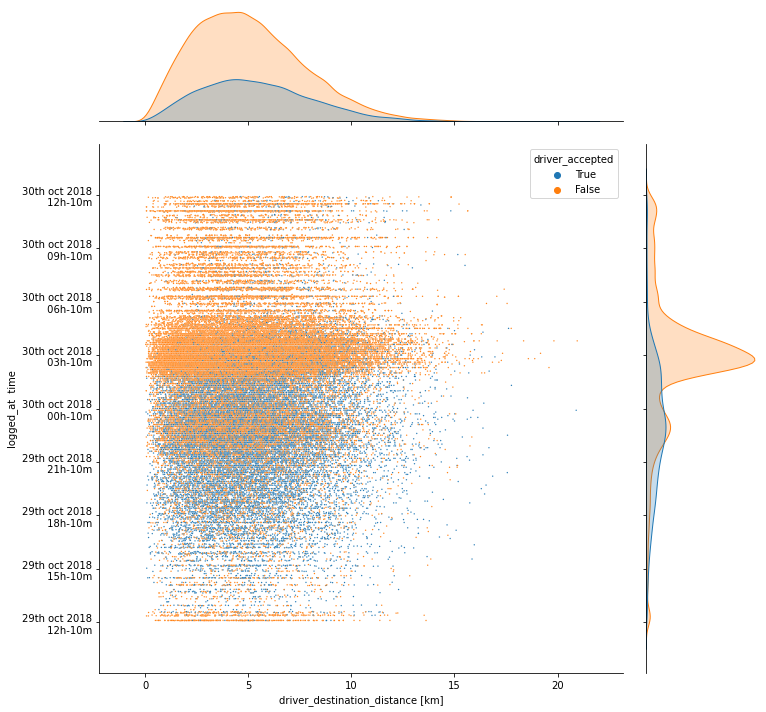

In [146]:
import matplotlib.dates as mpl_dates

y_time = pd.to_datetime(df.logged_at, unit='s')

h = sns.jointplot(data=df,
                  x='driver_destination_distance',
                  y=y_time,
                  hue='driver_accepted',
                  hue_order=[True, False],
                  s=2,
                  height=10,
                  ratio=4);

date_format = mpl_dates.DateFormatter('%dth oct %Y\n %Hh-%mm');
plt.gca().yaxis.set_major_formatter(date_format);

h.set_axis_labels('driver_destination_distance [km]', 'logged_at  time');

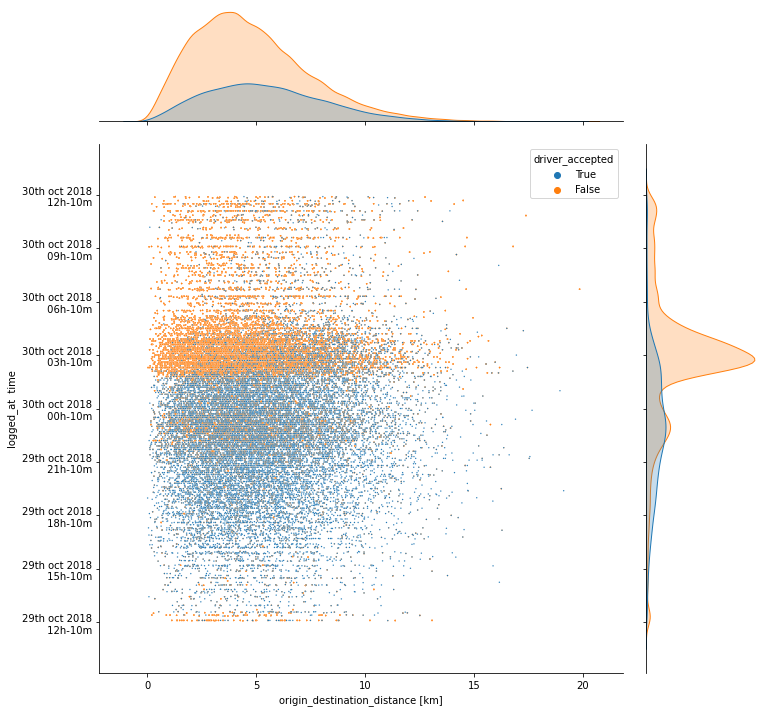

In [147]:
y_time = pd.to_datetime(df.logged_at, unit='s')

h = sns.jointplot(data=df,
                  x='origin_destination_distance',
                  y=y_time,
                  hue='driver_accepted',
                  hue_order=[True, False],
                  s=2,
                  height=10,
                  ratio=4);

date_format = mpl_dates.DateFormatter('%dth oct %Y\n %Hh-%mm');
plt.gca().yaxis.set_major_formatter(date_format);

h.set_axis_labels('origin_destination_distance [km]', 'logged_at  time');

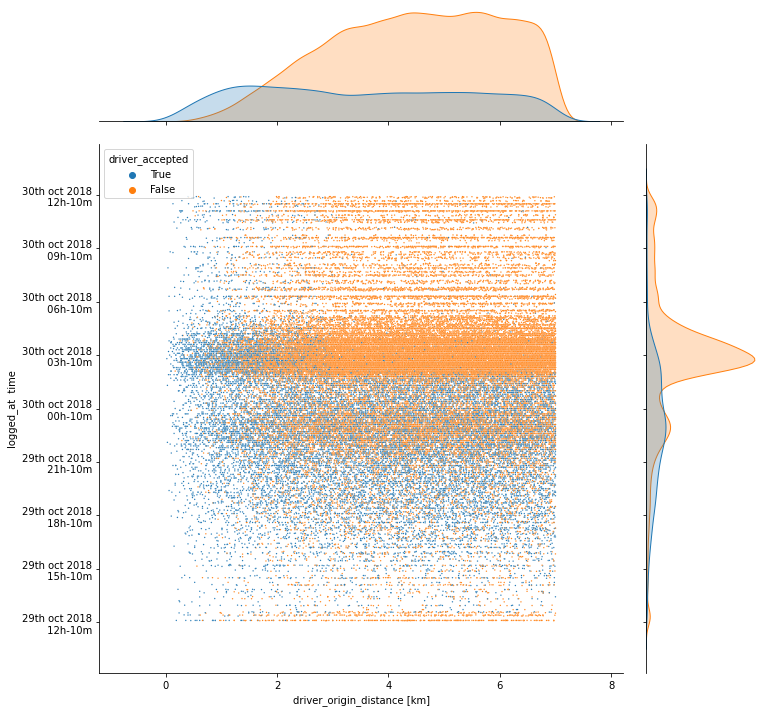

In [148]:
y_time = pd.to_datetime(df.logged_at, unit='s')

h = sns.jointplot(data=df,
                  x='driver_origin_distance',
                  y=y_time,
                  hue='driver_accepted',
                  hue_order=[True, False],
                  s=2,
                  height=10,
                  ratio=4);

date_format = mpl_dates.DateFormatter('%dth oct %Y\n %Hh-%mm');
plt.gca().yaxis.set_major_formatter(date_format);

h.set_axis_labels('driver_origin_distance [km]', 'logged_at  time');